***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade xgboost > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


In [4]:
SEED = 19
SUB_NBR = "11"

***

In [5]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats
import time
import yaml

import category_encoders as ce
import xgboost as xgb
from tqdm import tqdm
from tsforest.forecast import LightGBMForecaster
import optuna

import sys
sys.path.append("../utils")
from memory import reduce_mem_usage
from metrics import RMSSE, ranked_probability_score, scoring_function, binarize_predictions
from inventory import InventoryDaysPredictor
from features import Featurador

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

***
## loading data for assessment

In [6]:
raw = pd.read_parquet(f"{input_path}/train_data.parquet", columns=["sku", "date", "sold_quantity", "minutes_active"])
metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
raw = pd.merge(raw, metadata, how="inner", on="sku")

In [7]:
if ASSESS:
    dataset = (
        pd.read_parquet(f"{input_path}/train-m2.parquet")
        .rename({"date":"ds",}, axis=1,)
        .drop(["q_mean","q_std"], axis=1)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    
dataset["nrows"] = dataset.groupby("sku")["ds"].transform("count")
print(dataset.sku.nunique())
print(dataset.query("nrows == 30").sku.nunique())

531832
500404


In [8]:
# just for assessment
dataset = (
    dataset
    .query("nrows == 30")
    .query("ds in ('2021-02-01', '2021-03-02')")
    .reset_index(drop=True)
)
print(dataset.sku.nunique())

# skus to remove on validation
skus_to_remove = dataset.query("inventory_days > 30").sku.unique()
#dataset = dataset.query("inventory_days <= 30").reset_index(drop=True)
dataset = dataset.query("sku not in @skus_to_remove").reset_index(drop=True)
print(dataset.sku.nunique())

500404
272130


In [9]:
dataset["id_lower"] = dataset["inventory_days"].copy() 
dataset["id_upper"] = dataset["inventory_days"].copy()

idx = dataset.query("inventory_days > 30").index
dataset.loc[idx,"id_lower"] = 30
dataset.loc[idx,"id_upper"] = np.inf

In [10]:
idx0 = dataset.query("ds == '2021-02-01'").index
idx1 = dataset.query("ds == '2021-03-02'").index

# folds time-ranges
fold_tr = {
    0: ('2021-02-01', '2021-03-02'),
    1: ('2021-03-02', '2021-03-31')
}

dataset.loc[idx0,"fold"] = 0
dataset.loc[idx1,"fold"] = 1

print(dataset.query("fold==0").sku.nunique())
print(dataset.query("fold==1").sku.nunique())

272130
272130


In [11]:
numeric_cols = [
    "current_price",
    "listing_type_classic",
    "listing_type_premium",
    "shipping_logistic_type_fulfillment",
    "shipping_logistic_type_cross_docking",
    "shipping_logistic_type_drop_off",
    "shipping_payment_free_shipping",
    "shipping_payment_paid_shipping",
    "minutes_active",
    "weekday_1",
    "weekday_2",
    "weekday_3",
    "weekday_4",
    "weekday_5",
    "weekday_6",
    "weekday_7",
    "q_mean",
    "q_std",
    "target_stock",   
]
print("number of numeric:", len(numeric_cols))

categs_cols = [
    #"sku",
    "item_domain_id",
    #"item_id",
    #"site_id",
    "product_id",
    #"product_family_id",  
]
print("number of categs", len(categs_cols))

categs_to_encode = [
    #"sku",
    #"item_id",
    #"product_family_id",
]

target = "inventory_days"

input_cols = numeric_cols + categs_cols
print("total feats:", len(input_cols))

number of numeric: 19
number of categs 2
total feats: 21


In [12]:
dataset.loc[:,categs_cols].nunique()

item_domain_id    7553
product_id        6445
dtype: int64

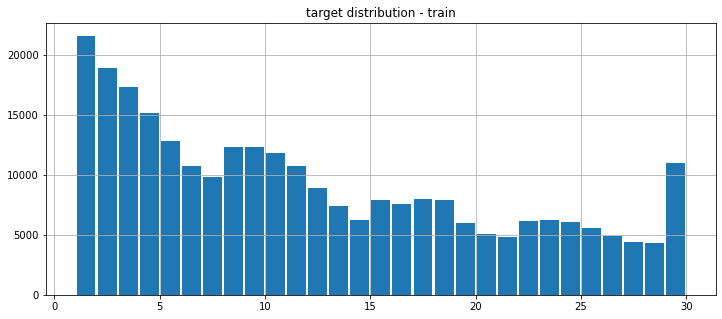

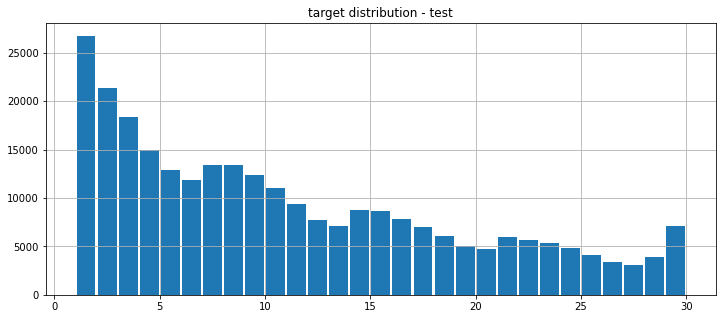

In [13]:
plt.figure(figsize=(12,5))
plt.hist(dataset.query("fold==0")[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - train")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(dataset.query("fold==1")[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - test")
plt.grid()
plt.show()

In [14]:
print("Uncensored rows (train):", len(dataset.query("fold==0").query("inventory_days > 30")) / 1e3)
print("Uncensored rows (valid):", len(dataset.query("fold==1").query("inventory_days > 30")) / 1e3)

Uncensored rows (train): 0.0
Uncensored rows (valid): 0.0


In [15]:
dataset.query("sku not in @skus_to_remove").sku.nunique()

272130

In [16]:
skus_assess_m2 = dataset.query("sku not in @skus_to_remove").sku.unique().tolist()

with open("../data/skus_assess_m2.yaml", "w") as file:
    yaml.dump(skus_assess_m2, file)
    file.close()
len(skus_assess_m2)

272130

***
## model training: assessment

In [17]:
model_params = {
    'booster': 'gbtree',
    #'sample_type': 'uniform',
    #'normalize_type': 'tree',
    #'rate_drop': 0.1,
    # 'skip_drop': 0.75,
    
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    #'aft_loss_distribution': 'normal',
    'aft_loss_distribution': 'logistic',
    #'aft_loss_distribution': 'extreme',
    'aft_loss_distribution_scale': 1.4,
    
    #'tree_method': 'exact',
    #'tree_method': 'approx',
    'tree_method': 'hist',
    'max_bin': 256,
    
    'grow_policy': 'lossguide',
    'max_leaves': 2**6-1,
    'min_child_weight': 50,
    'max_depth': 8,
    
    'learning_rate': 0.05,
    'max_delta_step':.5,
    
    'colsample_bytree':0.8,
    'subsample':0.95,
    
    'lambda':0.1,
    'seed':SEED,
}

------------------------------------------------------------------------------------------
Training model for site: MLA 

Training with fold 0
[0]	valid-aft-nloglik:4.47503
[25]	valid-aft-nloglik:4.19489
[50]	valid-aft-nloglik:3.97659
[75]	valid-aft-nloglik:3.83194
[100]	valid-aft-nloglik:3.75809
[125]	valid-aft-nloglik:3.73652
[150]	valid-aft-nloglik:3.73632
[175]	valid-aft-nloglik:3.73852
[186]	valid-aft-nloglik:3.73924


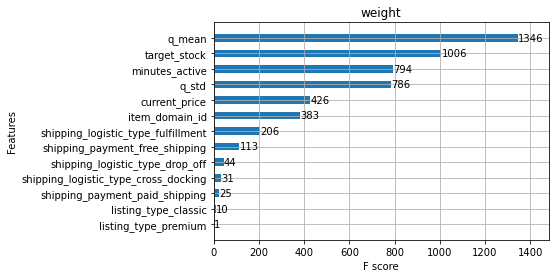

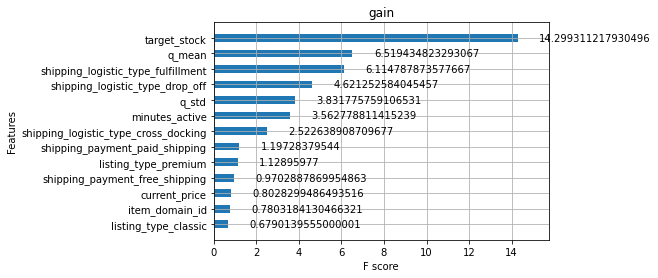

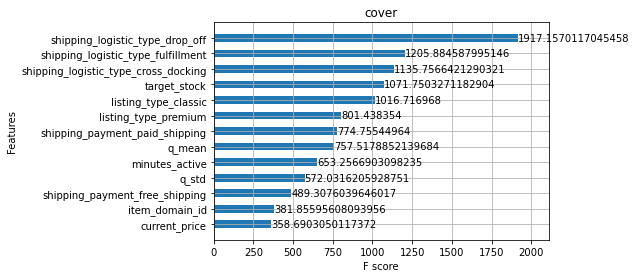

Training with fold 1
[0]	valid-aft-nloglik:4.61380
[25]	valid-aft-nloglik:4.32718
[50]	valid-aft-nloglik:4.10040
[75]	valid-aft-nloglik:3.94751
[100]	valid-aft-nloglik:3.86997
[125]	valid-aft-nloglik:3.84637
[150]	valid-aft-nloglik:3.84440
[175]	valid-aft-nloglik:3.84578
[192]	valid-aft-nloglik:3.84674


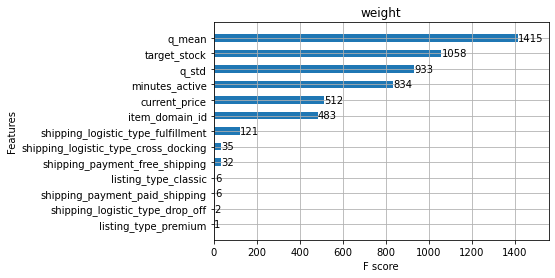

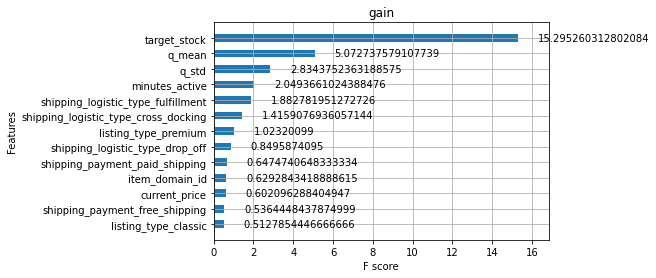

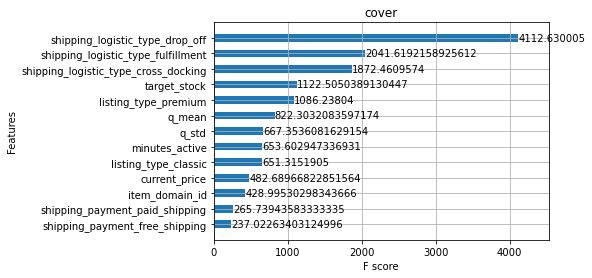

------------------------------------------------------------------------------------------
Training model for site: MLB 

Training with fold 0
[0]	valid-aft-nloglik:4.57953
[25]	valid-aft-nloglik:4.29325
[50]	valid-aft-nloglik:4.06726
[75]	valid-aft-nloglik:3.91362
[100]	valid-aft-nloglik:3.83245
[125]	valid-aft-nloglik:3.80700
[150]	valid-aft-nloglik:3.80507
[175]	valid-aft-nloglik:3.80648
[192]	valid-aft-nloglik:3.80732


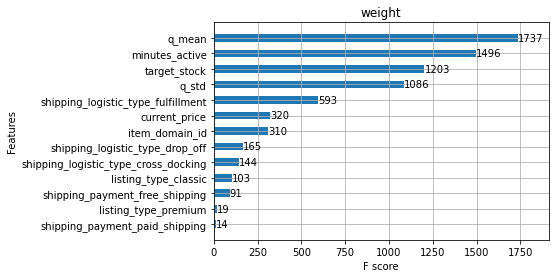

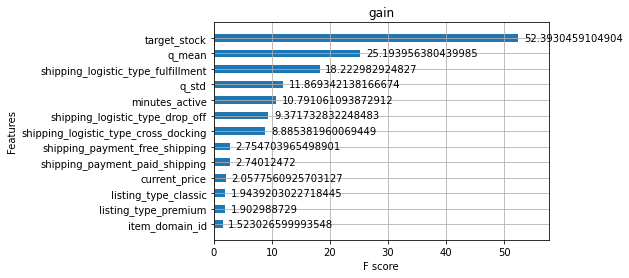

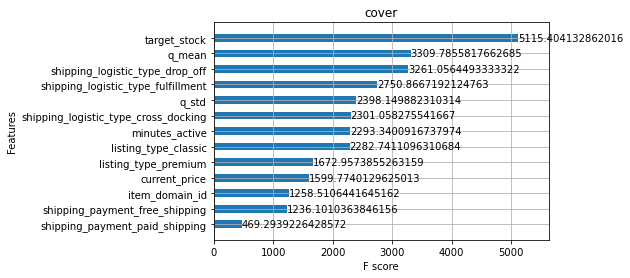

Training with fold 1
[0]	valid-aft-nloglik:4.76002
[25]	valid-aft-nloglik:4.46292
[50]	valid-aft-nloglik:4.22346
[75]	valid-aft-nloglik:4.05622
[100]	valid-aft-nloglik:3.96700
[125]	valid-aft-nloglik:3.93837
[150]	valid-aft-nloglik:3.93444
[175]	valid-aft-nloglik:3.93453
[200]	valid-aft-nloglik:3.93518
[206]	valid-aft-nloglik:3.93517


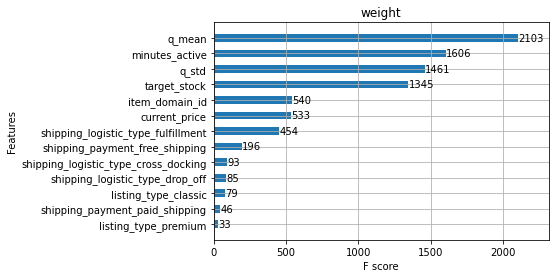

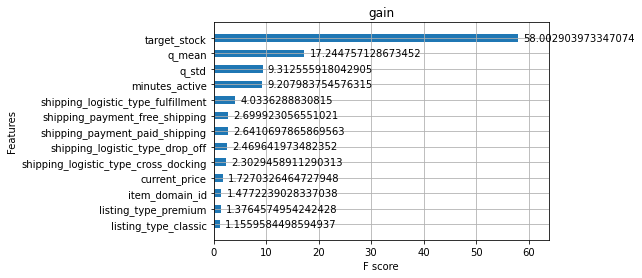

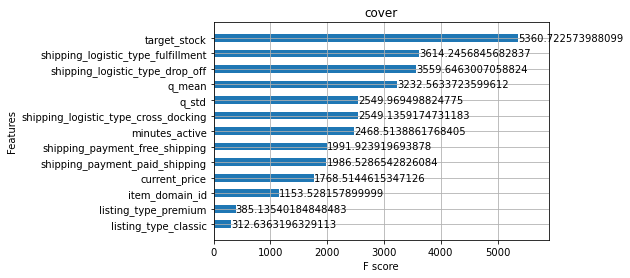

------------------------------------------------------------------------------------------
Training model for site: MLM 

Training with fold 0
[0]	valid-aft-nloglik:4.52822
[25]	valid-aft-nloglik:4.24551
[50]	valid-aft-nloglik:4.02387
[75]	valid-aft-nloglik:3.87490
[100]	valid-aft-nloglik:3.79651
[125]	valid-aft-nloglik:3.77253
[150]	valid-aft-nloglik:3.77157
[175]	valid-aft-nloglik:3.77325
[189]	valid-aft-nloglik:3.77395


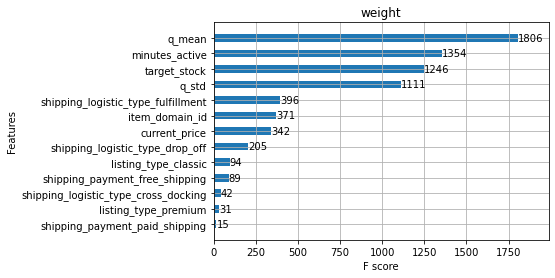

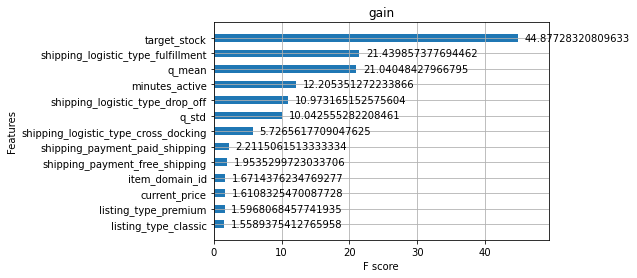

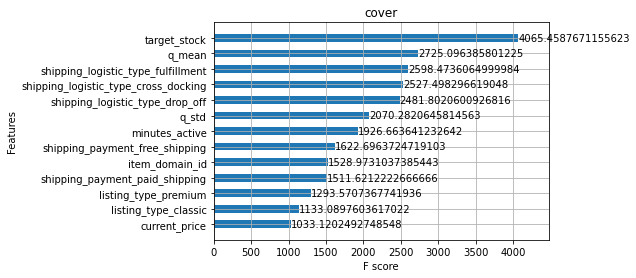

Training with fold 1
[0]	valid-aft-nloglik:4.69062
[25]	valid-aft-nloglik:4.39771
[50]	valid-aft-nloglik:4.16346
[75]	valid-aft-nloglik:4.00258
[100]	valid-aft-nloglik:3.91868
[125]	valid-aft-nloglik:3.89297
[150]	valid-aft-nloglik:3.89064
[175]	valid-aft-nloglik:3.89203
[192]	valid-aft-nloglik:3.89283


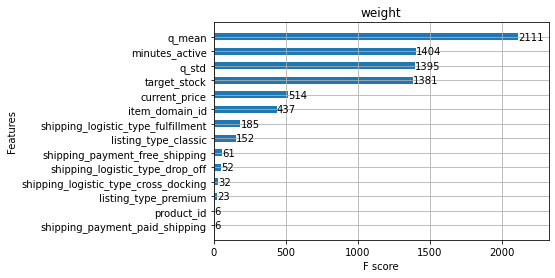

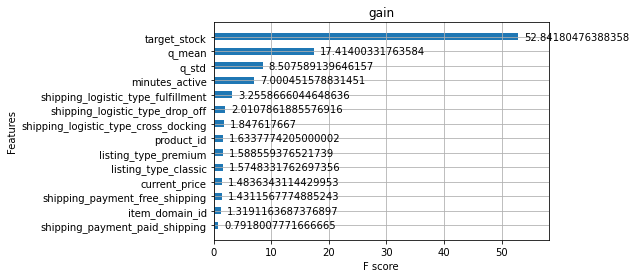

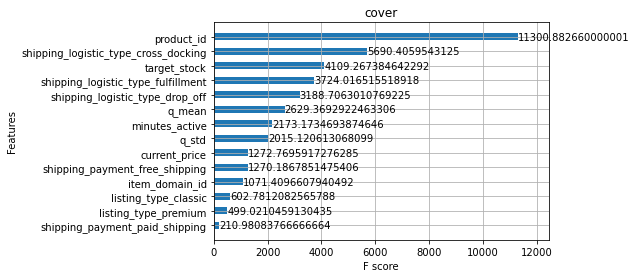

In [18]:
sites = ["MLA","MLB","MLM"]
models_by_site = {"MLA":list(), "MLB":list(), "MLM":list(),}
oof_preds = {"MLA":list(), "MLB":list(), "MLM":list(),}

for site in sites:
    print("-"*90)
    print(f"Training model for site: {site} \n")
    
    for fold in range(2):
        print(f"Training with fold {fold}")
    
        train_dset = (
            dataset
            .query("site_id == @site")
            .query("fold == @fold")
            .reset_index(drop=True)
        )
        valid_dset = (
            dataset
            .query("site_id == @site")
            .query("fold != @fold")
            .reset_index(drop=True)
        )
        
        feat = Featurador(raw)
        feat.fit(*fold_tr[fold], site=site)
        train_dset = feat.transform(train_dset)
        valid_dset = feat.transform(valid_dset)
        
        encoder = ce.CatBoostEncoder()
        train_dset[categs_cols] = encoder.fit_transform(
            train_dset[categs_cols], 
            train_dset.eval("target_stock / inventory_days")
        )
        valid_dset[categs_cols] = encoder.transform(valid_dset[categs_cols])

        # train data matrix
        dtrain = xgb.DMatrix(
            data = train_dset.loc[:, numeric_cols+categs_cols], 
        )
        dtrain.set_float_info('label_lower_bound', train_dset.id_lower.values)
        dtrain.set_float_info('label_upper_bound', train_dset.id_upper.values)
        
        # sample of train data matrix for metric tracking
        sample_index = train_dset.sample(frac=0.25).index
        dtrain_sample = xgb.DMatrix(
            data = train_dset.loc[sample_index, numeric_cols+categs_cols],
        )
        dtrain_sample.set_float_info('label_lower_bound', train_dset.loc[sample_index].id_lower.values)
        dtrain_sample.set_float_info('label_upper_bound', train_dset.loc[sample_index].id_upper.values)

        # valid data matrix
        dvalid = xgb.DMatrix(
            data = valid_dset.loc[:, numeric_cols+categs_cols],
        )
        dvalid.set_float_info('label_lower_bound', valid_dset.id_lower.values)
        dvalid.set_float_info('label_upper_bound', valid_dset.id_upper.values)

        model = xgb.train(
            params = model_params,
            dtrain = dtrain,
            evals = [
                (dvalid,"valid"), 
                #(dtrain_sample,"train_sample")
            ],
            num_boost_round = 5000,
            early_stopping_rounds = 50,
            verbose_eval = 25,
        )

        xgb.plot_importance(model, height=0.5, importance_type="weight", title="weight")
        xgb.plot_importance(model, height=0.5, importance_type="gain", title="gain")
        xgb.plot_importance(model, height=0.5, importance_type="cover", title="cover")
        plt.show()

        valid_dset["pred"] = np.clip(model.predict(dvalid), a_min=None, a_max=30)
        valid_dset = binarize_predictions(valid_dset)
        oof_preds[site].append(valid_dset)
        models_by_site[site].append(model)
    

In [19]:
for site in sites:
    for fold,(oof,model) in enumerate(zip(oof_preds[site],models_by_site[site])):
        mean_ae = oof.query("sku not in @skus_to_remove").eval("abs(inventory_days - pred)").mean()
        median_ae = oof.query("sku not in @skus_to_remove").eval("abs(inventory_days - pred)").median()
        print(
            site, "-", f"train_fold={fold}", "-",
            f"best_iteration: {model.best_iteration}", "-",
            f"best_score: {model.best_score:0.4f}", "-", 
            f"mean_ae: {mean_ae:0.4f}", "-",
            f"median_ae: {median_ae:0.4f}",
        )
    print()

MLA - train_fold=0 - best_iteration: 137 - best_score: 3.7354 - mean_ae: 5.3001 - median_ae: 3.9588
MLA - train_fold=1 - best_iteration: 143 - best_score: 3.8443 - mean_ae: 6.3622 - median_ae: 4.5855

MLB - train_fold=0 - best_iteration: 142 - best_score: 3.8048 - mean_ae: 5.5785 - median_ae: 4.1927
MLB - train_fold=1 - best_iteration: 157 - best_score: 3.9344 - mean_ae: 6.3207 - median_ae: 4.6415

MLM - train_fold=0 - best_iteration: 139 - best_score: 3.7709 - mean_ae: 5.5082 - median_ae: 4.0719
MLM - train_fold=1 - best_iteration: 143 - best_score: 3.8906 - mean_ae: 6.2394 - median_ae: 4.5510



In [20]:
oof0 = pd.concat([
    oof_preds["MLA"][0][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    oof_preds["MLB"][0][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    oof_preds["MLM"][0][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    ], ignore_index=True
).query("sku not in @skus_to_remove")
oof0["valid_fold"] = oof0["valid_fold"].astype(int)

oof1 = pd.concat([
    oof_preds["MLA"][1][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    oof_preds["MLB"][1][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    oof_preds["MLM"][1][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    ], ignore_index=True
).query("sku not in @skus_to_remove")
oof1["valid_fold"] = oof1["valid_fold"].astype(int)

In [21]:
print("Overall Mean AE on fold1:  ", oof0.eval("abs(inventory_days-pred)").mean())
print("Overall Median AE on fold1:", oof0.eval("abs(inventory_days-pred)").median())

Overall Mean AE on fold1:   5.524911867174385
Overall Median AE on fold1: 4.12185001373291


In [22]:
print("Overall Mean AE on fold0:  ", oof1.eval("abs(inventory_days-pred)").mean())
print("Overall Median AE on fold0:", oof1.eval("abs(inventory_days-pred)").median())

Overall Mean AE on fold0:   6.290871551049495
Overall Median AE on fold0: 4.597158193588257


In [23]:
oof_concat = pd.concat([oof0,oof1], ignore_index=True)
oof_concat.to_csv("../results/oof_preds_xgb-m2.csv", index=False)

***
## analysis of OOF predictions

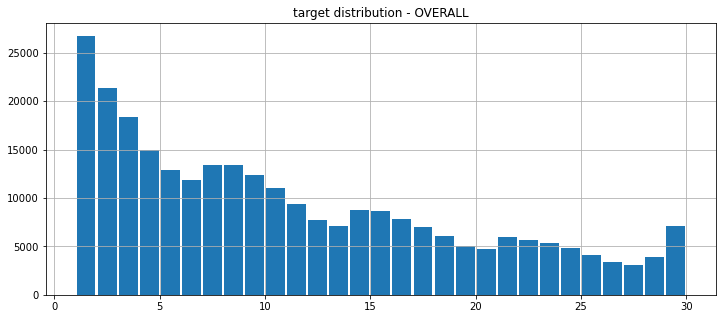

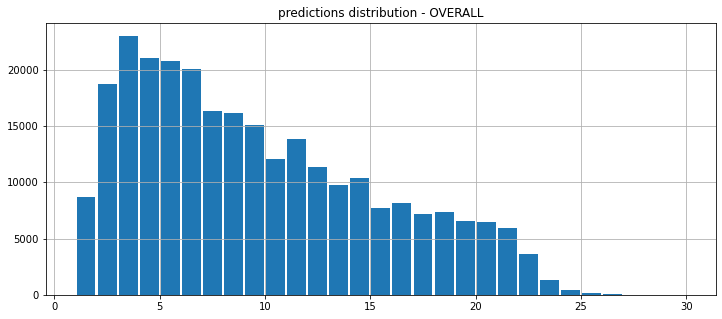

In [24]:
plt.figure(figsize=(12,5))
plt.hist(oof0["inventory_days"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"target distribution - OVERALL")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof0["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"predictions distribution - OVERALL")
plt.grid()
plt.show()

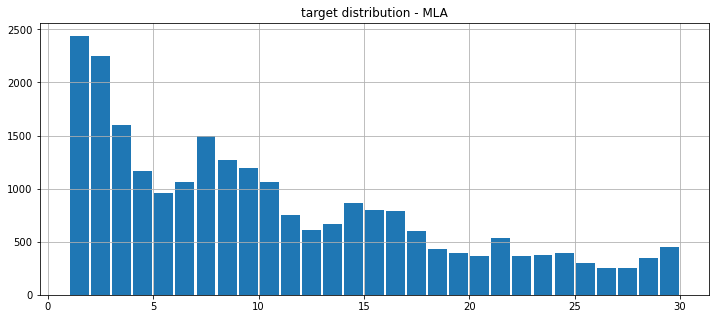

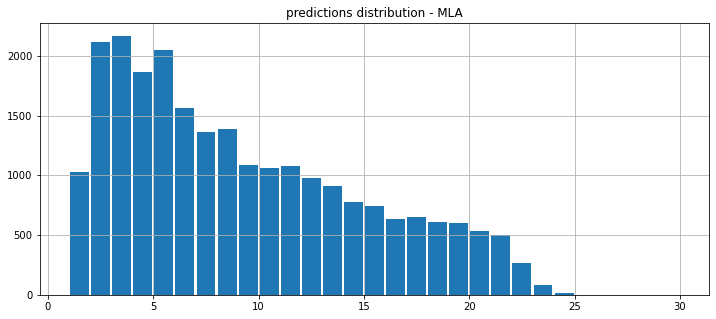

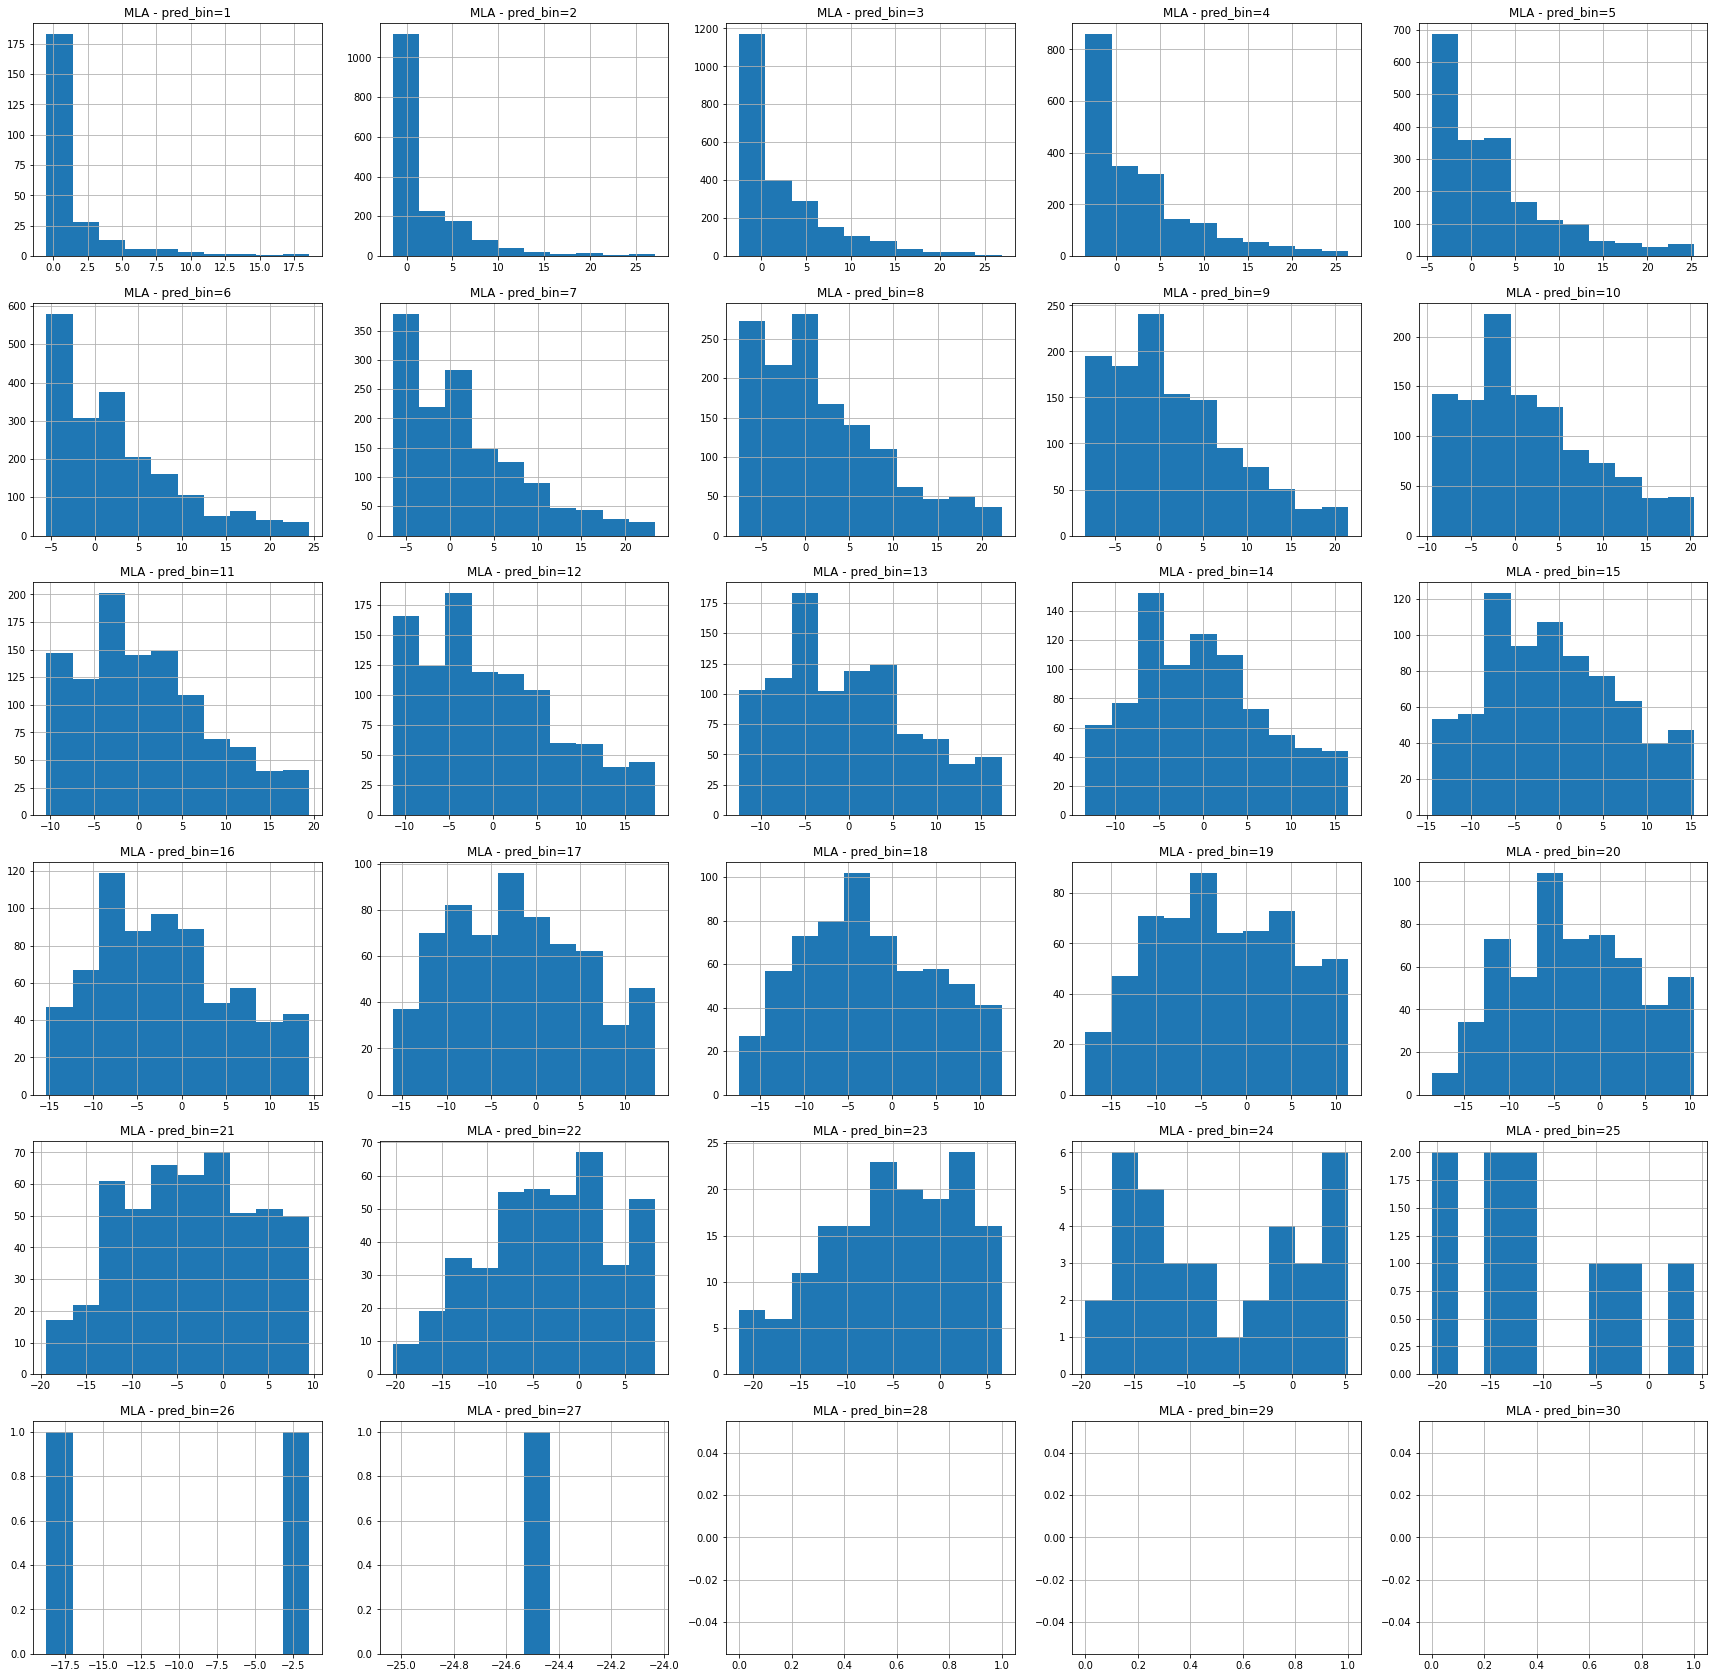

In [25]:
# results for MLA
site = "MLA"
train_fold = 0

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"target distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"predictions distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[site][train_fold].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"{site} - pred_bin={d}")
    plt.grid()
plt.show()

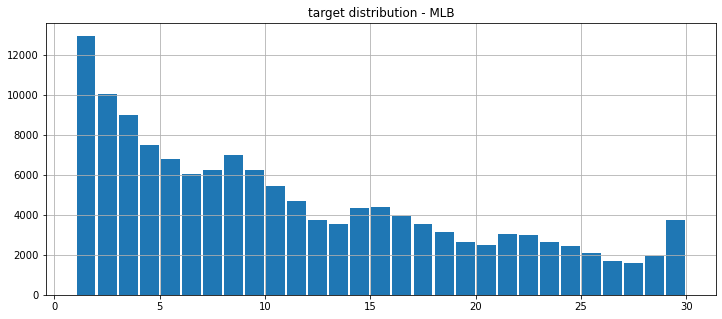

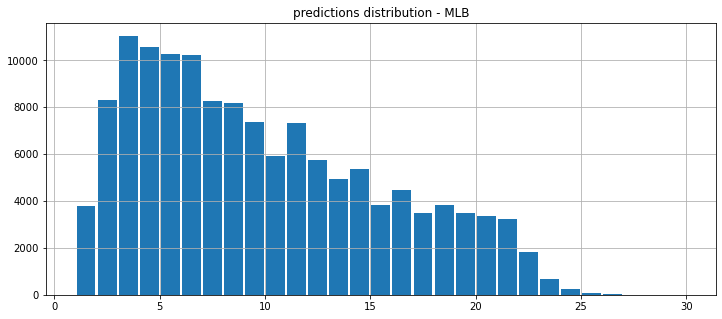

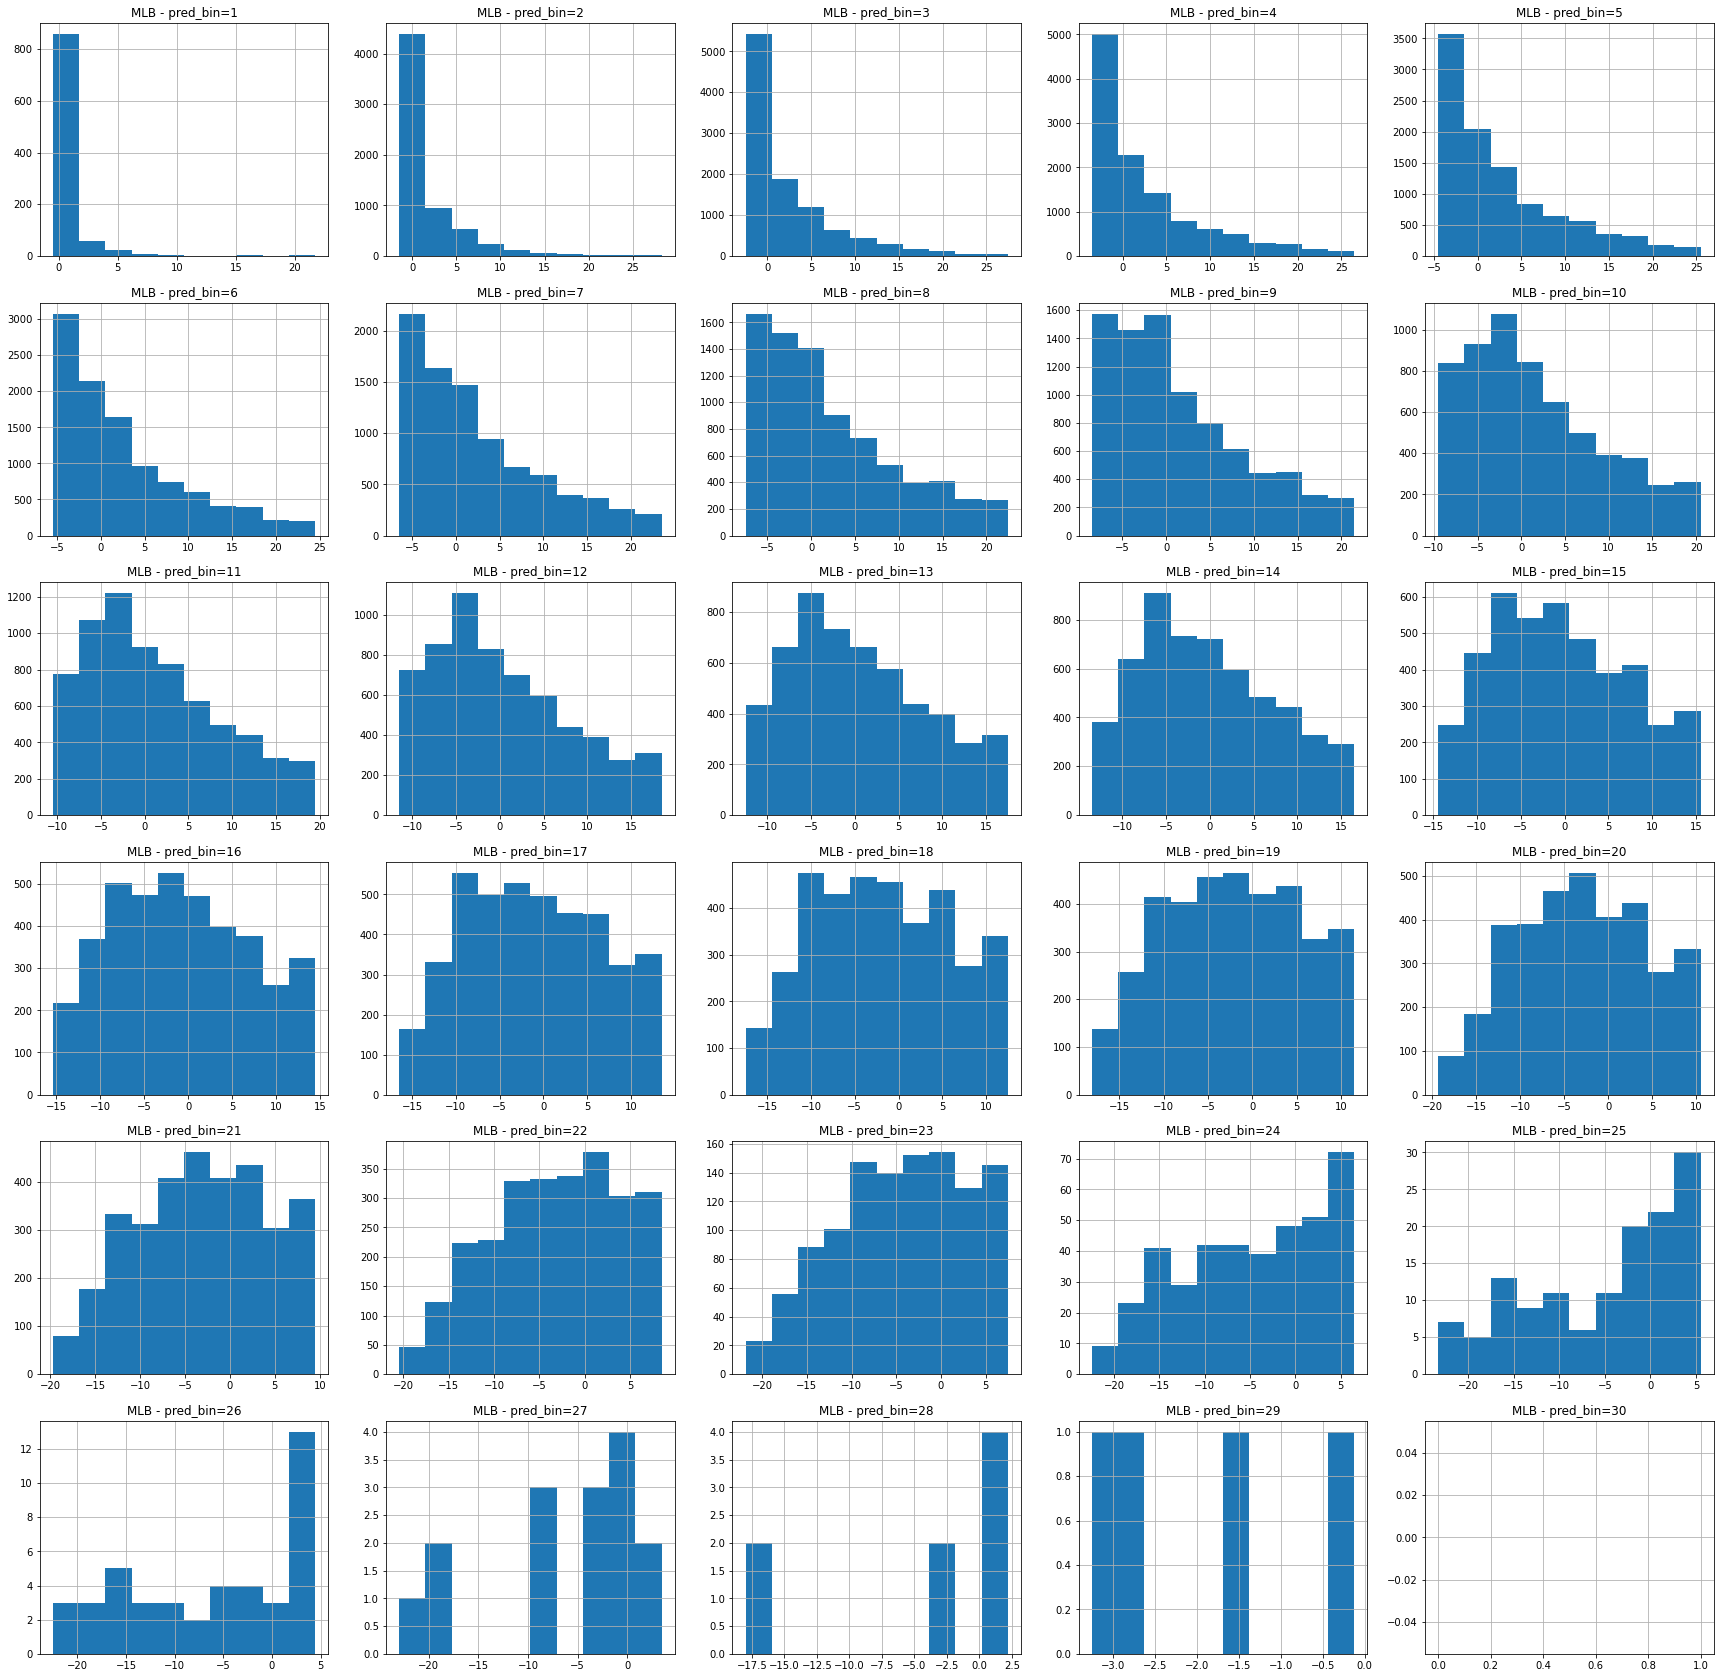

In [26]:
# results for MLB
site = "MLB"
train_fold = 0

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"target distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"predictions distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[site][train_fold].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"{site} - pred_bin={d}")
    plt.grid()
plt.show()

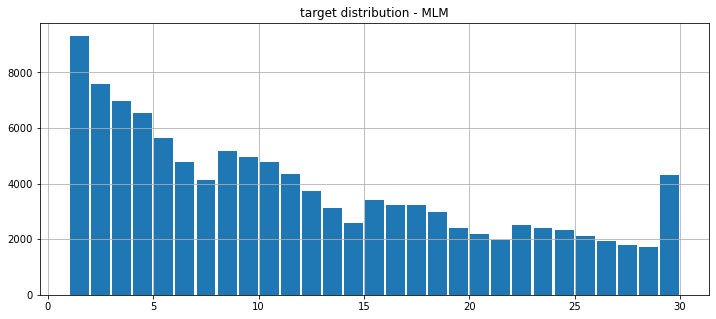

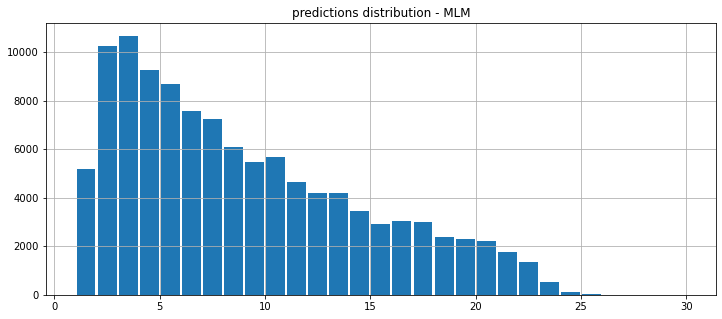

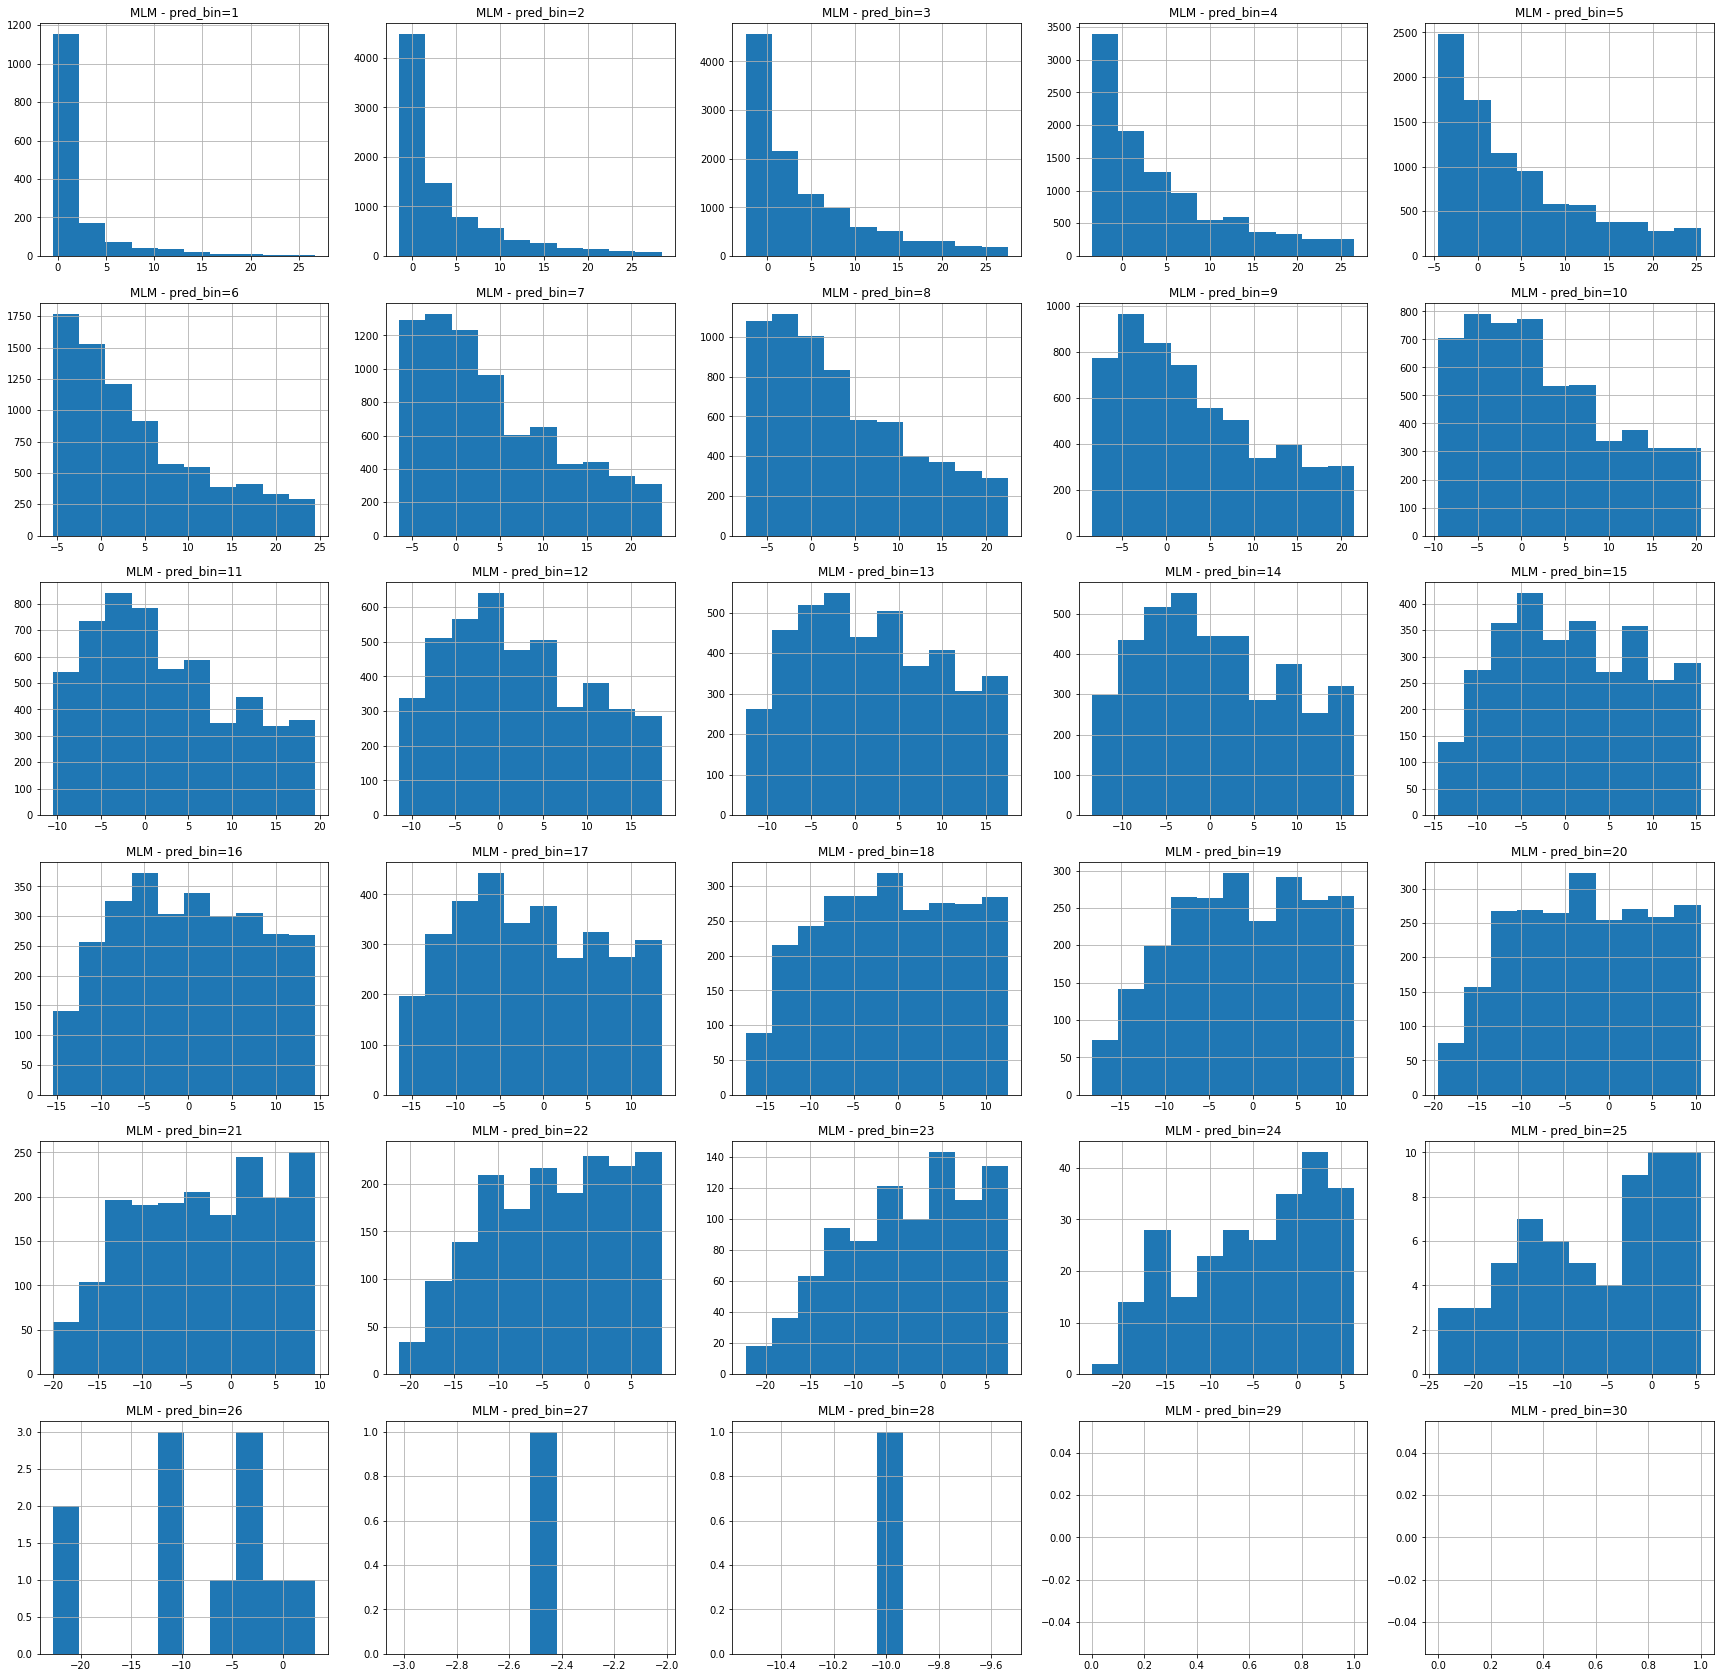

In [27]:
# results for MLM
site = "MLM"
train_fold = 1

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"target distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"predictions distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[site][train_fold].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"{site} - pred_bin={d}")
    plt.grid()
plt.show()

***
## model training

In [28]:
dataset = (
    pd.read_parquet(f"{input_path}/train-m2.parquet")
    .query("sku in @skus_assess_m2")
    .query("inventory_days <= 30")
    .rename({"date":"ds",}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
dataset["nrows"] = dataset.groupby("sku")["ds"].transform("count")
print("n rows:", len(dataset) / 1e6)
print("n skus:", dataset.sku.nunique())

n rows: 7.871542
n skus: 272130


In [29]:
test = (
    pd.read_parquet(f"{input_path}/test-m2.parquet")
    .query("sku in @skus_assess_m2")
    .reset_index(drop=True)
)

print("n rows:", len(test) / 1e3)
print("n skus:", test.sku.nunique() / 1e3)

n rows: 272.13
n skus: 272.13


In [30]:
dataset["id_lower"] = dataset["inventory_days"].copy() 
dataset["id_upper"] = dataset["inventory_days"].copy()

idx = dataset.query("inventory_days > 30").index
dataset.loc[idx,"id_lower"] = 30
dataset.loc[idx,"id_upper"] = np.inf

print("n of uncensored:", len(idx)/1e3)

n of uncensored: 0.0


In [31]:
encoder = ce.CatBoostEncoder()
dataset[categs_cols] = encoder.fit_transform(
    dataset[categs_cols], 
    dataset.eval("target_stock / inventory_days")
)

test[categs_cols] = encoder.transform(test[categs_cols])

------------------------------------------------------------------------------------------
Training model for site: MLA
Training model for seed: 2 

[0]	train_sample-aft-nloglik:4.62136
[25]	train_sample-aft-nloglik:4.33095
[50]	train_sample-aft-nloglik:4.10017
[75]	train_sample-aft-nloglik:3.94131
[100]	train_sample-aft-nloglik:3.85424
[125]	train_sample-aft-nloglik:3.82209
[149]	train_sample-aft-nloglik:3.81468


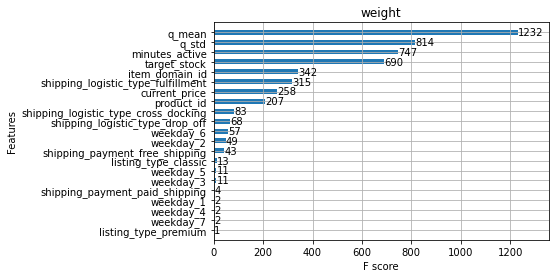

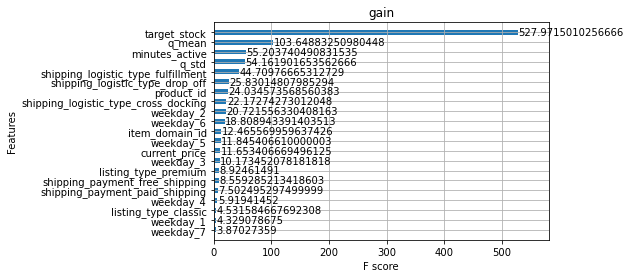

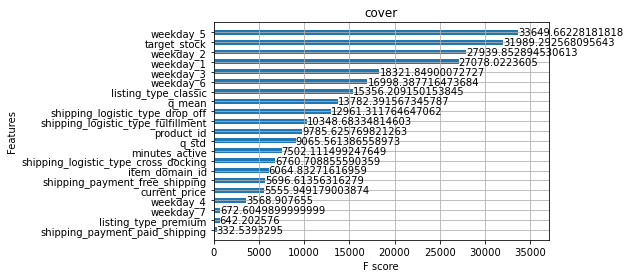

Elapsed time for model training: 0.11842534939448039 min
Training model for seed: 11 

[0]	train_sample-aft-nloglik:4.62136
[25]	train_sample-aft-nloglik:4.33095
[50]	train_sample-aft-nloglik:4.10017
[75]	train_sample-aft-nloglik:3.94119
[100]	train_sample-aft-nloglik:3.85564
[125]	train_sample-aft-nloglik:3.82305
[149]	train_sample-aft-nloglik:3.81498


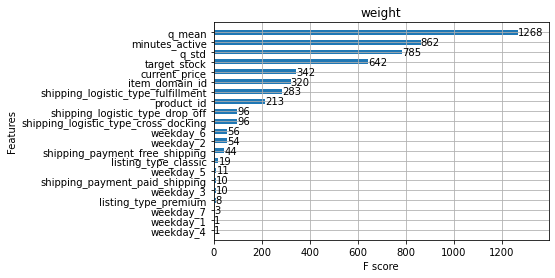

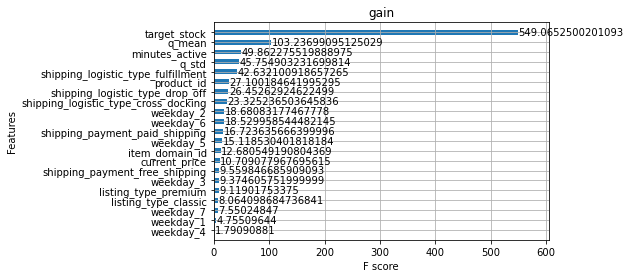

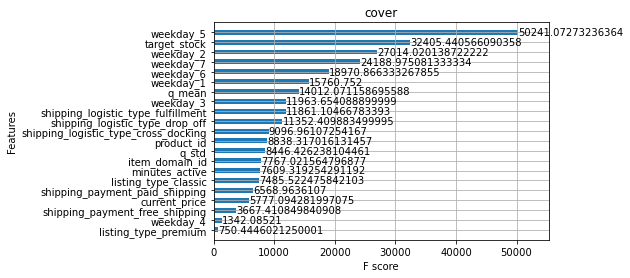

Elapsed time for model training: 0.10980441570281982 min
Training model for seed: 19 

[0]	train_sample-aft-nloglik:4.62136
[25]	train_sample-aft-nloglik:4.33095
[50]	train_sample-aft-nloglik:4.10017
[75]	train_sample-aft-nloglik:3.94135
[100]	train_sample-aft-nloglik:3.85361
[125]	train_sample-aft-nloglik:3.82154
[149]	train_sample-aft-nloglik:3.81483


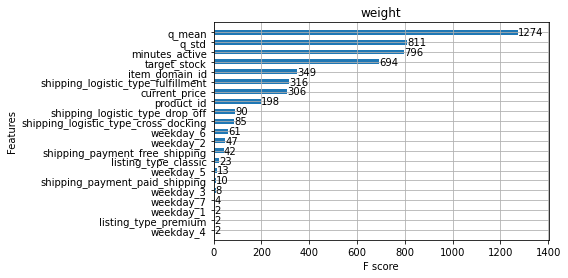

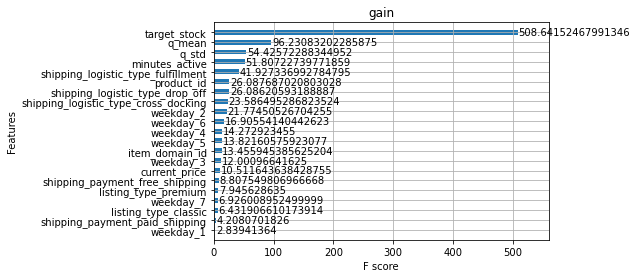

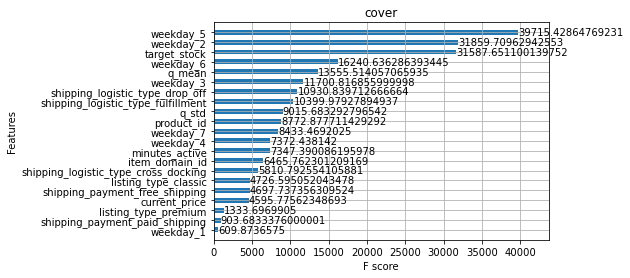

Elapsed time for model training: 0.12860873540242512 min
Training model for seed: 23 

[0]	train_sample-aft-nloglik:4.62136
[25]	train_sample-aft-nloglik:4.33095
[50]	train_sample-aft-nloglik:4.10017
[75]	train_sample-aft-nloglik:3.94114
[100]	train_sample-aft-nloglik:3.85636
[125]	train_sample-aft-nloglik:3.82289
[149]	train_sample-aft-nloglik:3.81497


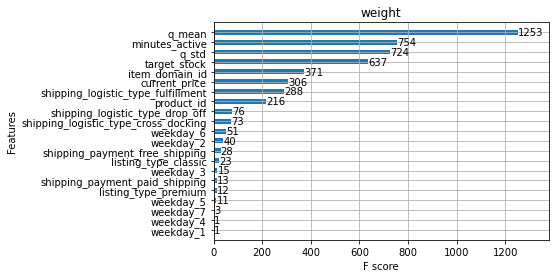

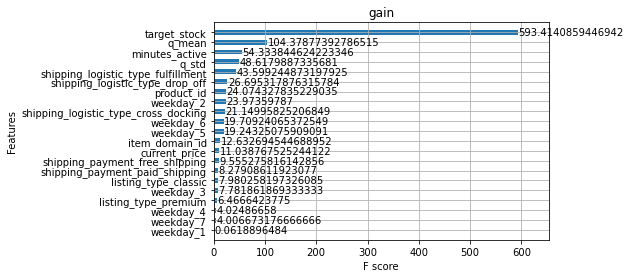

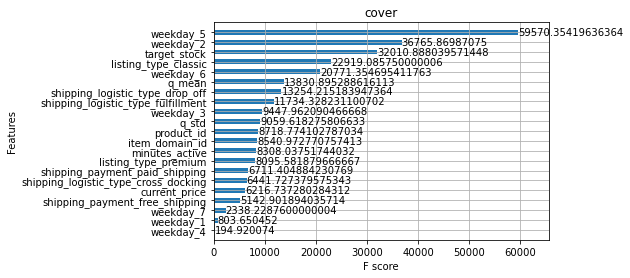

Elapsed time for model training: 0.1268834630648295 min
Training model for seed: 41 

[0]	train_sample-aft-nloglik:4.62136
[25]	train_sample-aft-nloglik:4.33095
[50]	train_sample-aft-nloglik:4.10017
[75]	train_sample-aft-nloglik:3.94130
[100]	train_sample-aft-nloglik:3.85460
[125]	train_sample-aft-nloglik:3.82272
[149]	train_sample-aft-nloglik:3.81573


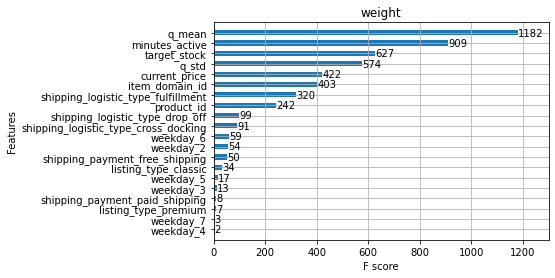

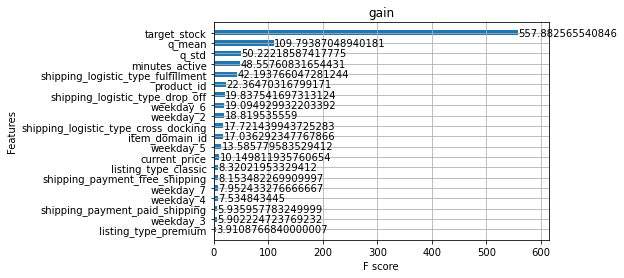

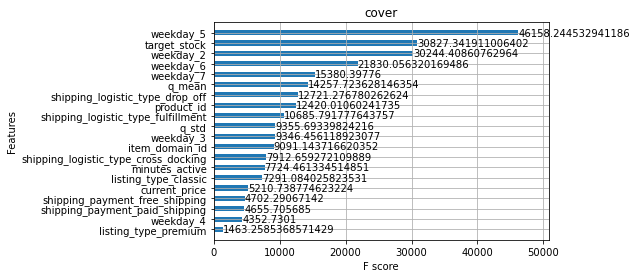

Elapsed time for model training: 0.12983283201853435 min
------------------------------------------------------------------------------------------
Training model for site: MLB
Training model for seed: 2 

[0]	train_sample-aft-nloglik:4.63973
[25]	train_sample-aft-nloglik:4.34831
[50]	train_sample-aft-nloglik:4.11627
[75]	train_sample-aft-nloglik:3.95595
[100]	train_sample-aft-nloglik:3.86825
[125]	train_sample-aft-nloglik:3.83612
[149]	train_sample-aft-nloglik:3.82878


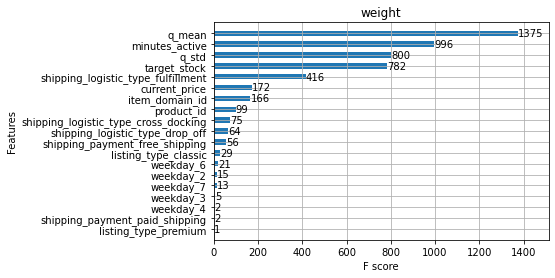

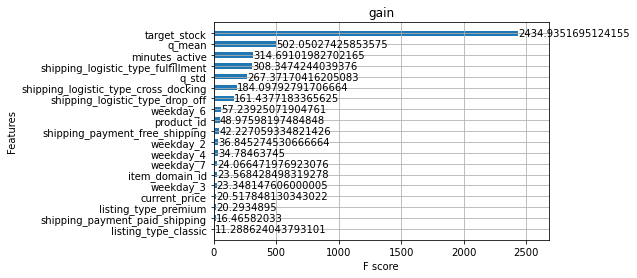

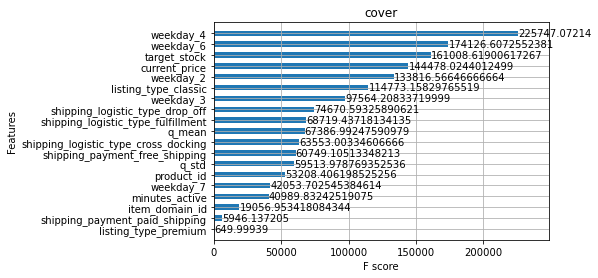

Elapsed time for model training: 0.6139602820078532 min
Training model for seed: 11 

[0]	train_sample-aft-nloglik:4.63973
[25]	train_sample-aft-nloglik:4.34831
[50]	train_sample-aft-nloglik:4.11627
[75]	train_sample-aft-nloglik:3.95587
[100]	train_sample-aft-nloglik:3.86982
[125]	train_sample-aft-nloglik:3.83721
[149]	train_sample-aft-nloglik:3.82910


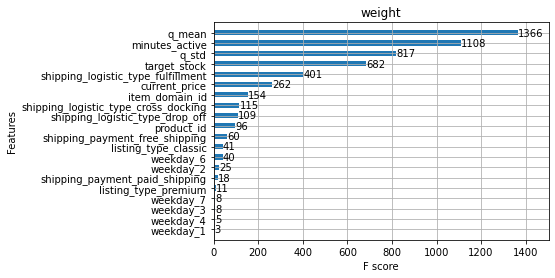

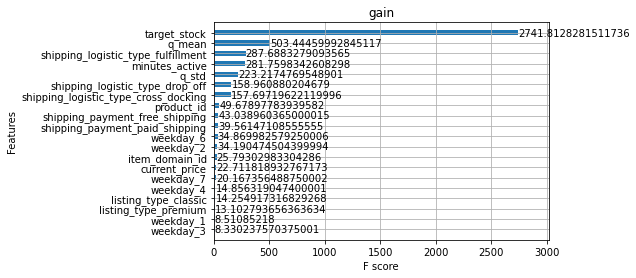

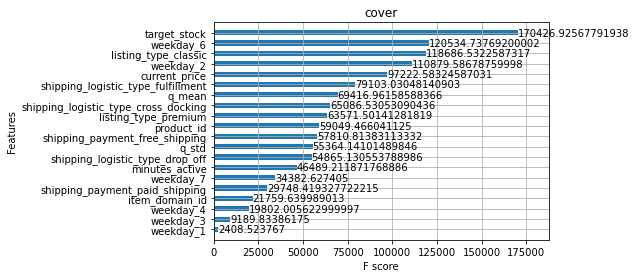

Elapsed time for model training: 0.6594457030296326 min
Training model for seed: 19 

[0]	train_sample-aft-nloglik:4.63973
[25]	train_sample-aft-nloglik:4.34831
[50]	train_sample-aft-nloglik:4.11627
[75]	train_sample-aft-nloglik:3.95595
[100]	train_sample-aft-nloglik:3.86768
[125]	train_sample-aft-nloglik:3.83571
[149]	train_sample-aft-nloglik:3.82893


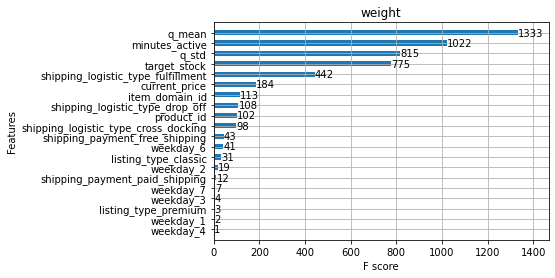

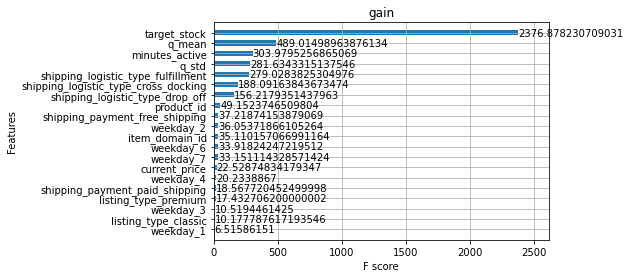

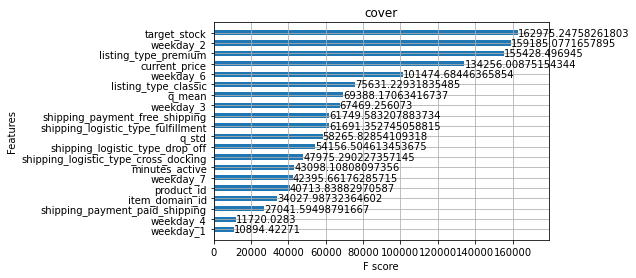

Elapsed time for model training: 0.7343020836512247 min
Training model for seed: 23 

[0]	train_sample-aft-nloglik:4.63973
[25]	train_sample-aft-nloglik:4.34831
[50]	train_sample-aft-nloglik:4.11627
[75]	train_sample-aft-nloglik:3.95579
[100]	train_sample-aft-nloglik:3.87027
[125]	train_sample-aft-nloglik:3.83698
[149]	train_sample-aft-nloglik:3.82904


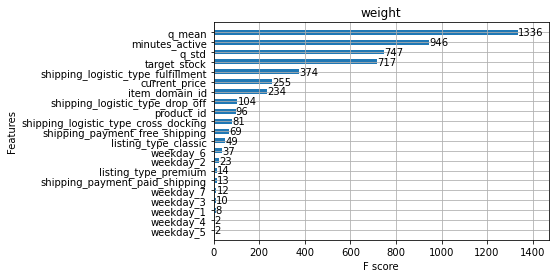

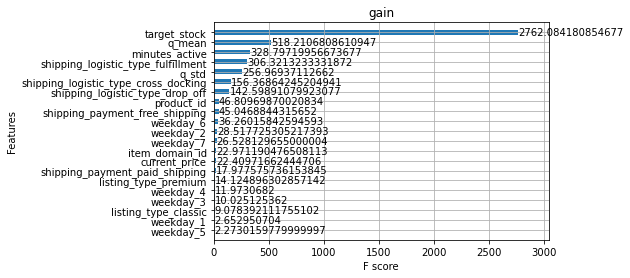

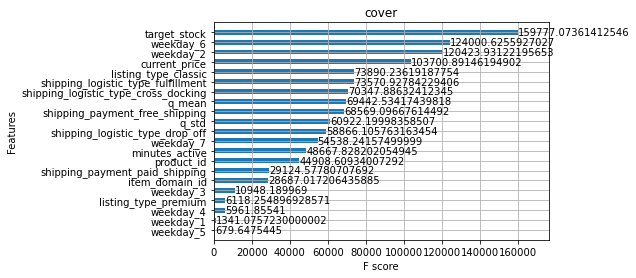

Elapsed time for model training: 0.7697698513666789 min
Training model for seed: 41 

[0]	train_sample-aft-nloglik:4.63973
[25]	train_sample-aft-nloglik:4.34831
[50]	train_sample-aft-nloglik:4.11627
[75]	train_sample-aft-nloglik:3.95594
[100]	train_sample-aft-nloglik:3.86865
[125]	train_sample-aft-nloglik:3.83678
[149]	train_sample-aft-nloglik:3.82983


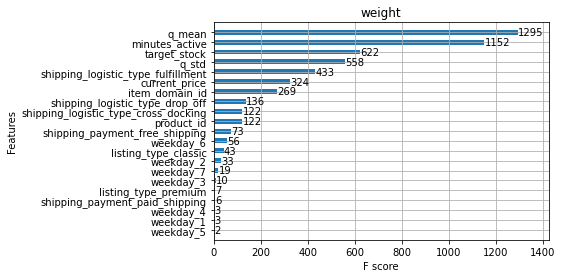

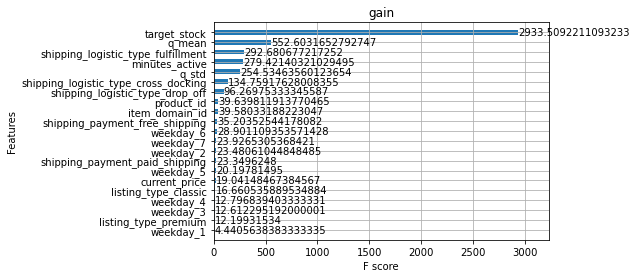

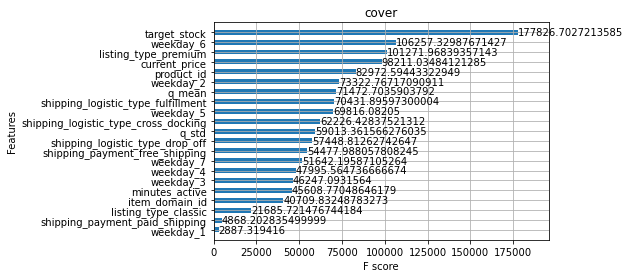

Elapsed time for model training: 0.812887450059255 min
------------------------------------------------------------------------------------------
Training model for site: MLM
Training model for seed: 2 

[0]	train_sample-aft-nloglik:4.54302
[25]	train_sample-aft-nloglik:4.25739
[50]	train_sample-aft-nloglik:4.03261
[75]	train_sample-aft-nloglik:3.88036
[100]	train_sample-aft-nloglik:3.79882
[125]	train_sample-aft-nloglik:3.76927
[149]	train_sample-aft-nloglik:3.76253


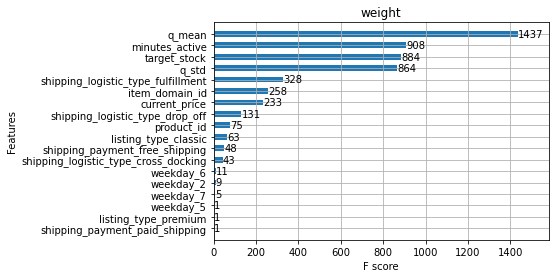

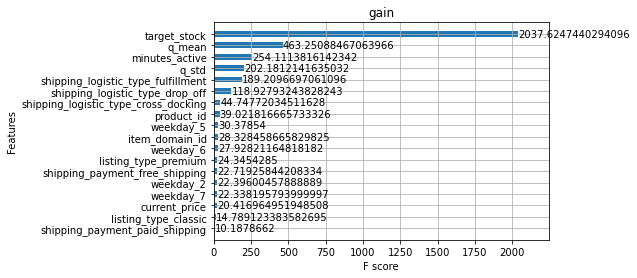

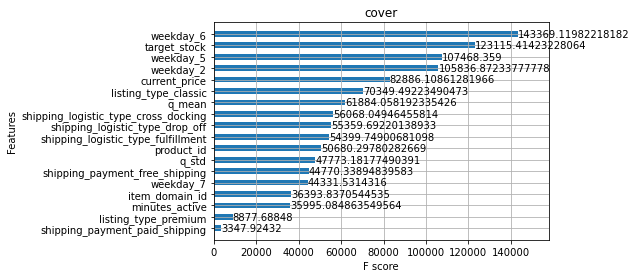

Elapsed time for model training: 0.697467569510142 min
Training model for seed: 11 

[0]	train_sample-aft-nloglik:4.54302
[25]	train_sample-aft-nloglik:4.25739
[50]	train_sample-aft-nloglik:4.03261
[75]	train_sample-aft-nloglik:3.88028
[100]	train_sample-aft-nloglik:3.80065
[125]	train_sample-aft-nloglik:3.77041
[149]	train_sample-aft-nloglik:3.76286


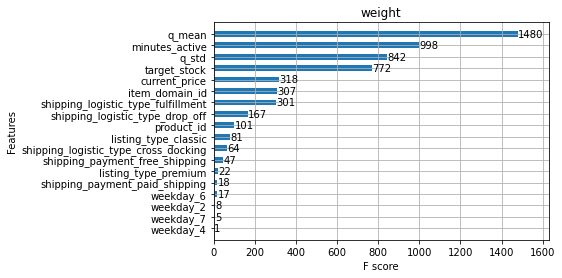

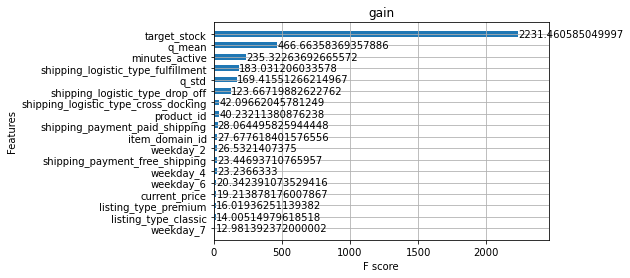

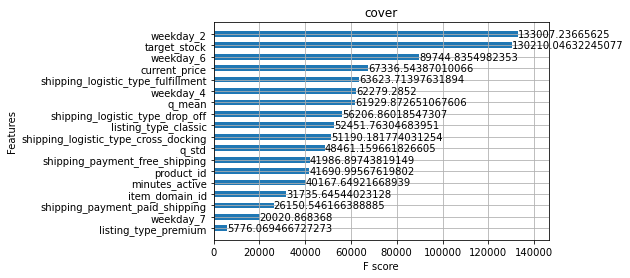

Elapsed time for model training: 0.7881199717521667 min
Training model for seed: 19 

[0]	train_sample-aft-nloglik:4.54302
[25]	train_sample-aft-nloglik:4.25739
[50]	train_sample-aft-nloglik:4.03260
[75]	train_sample-aft-nloglik:3.88035
[100]	train_sample-aft-nloglik:3.79787
[125]	train_sample-aft-nloglik:3.76871
[149]	train_sample-aft-nloglik:3.76268


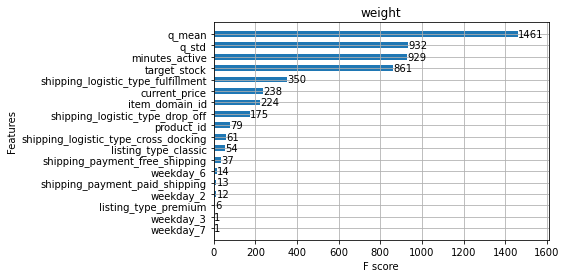

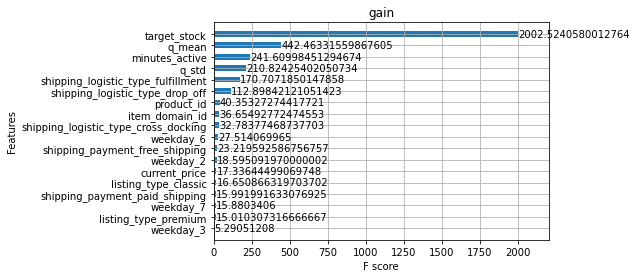

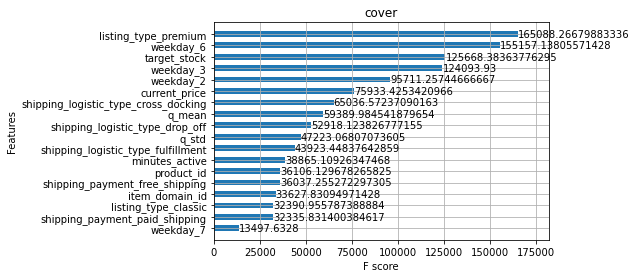

Elapsed time for model training: 0.8210965037345886 min
Training model for seed: 23 

[0]	train_sample-aft-nloglik:4.54302
[25]	train_sample-aft-nloglik:4.25739
[50]	train_sample-aft-nloglik:4.03261
[75]	train_sample-aft-nloglik:3.88018
[100]	train_sample-aft-nloglik:3.80123
[125]	train_sample-aft-nloglik:3.77007
[149]	train_sample-aft-nloglik:3.76278


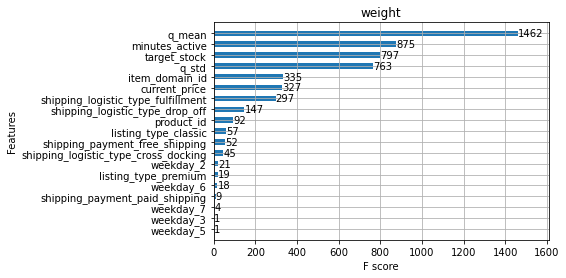

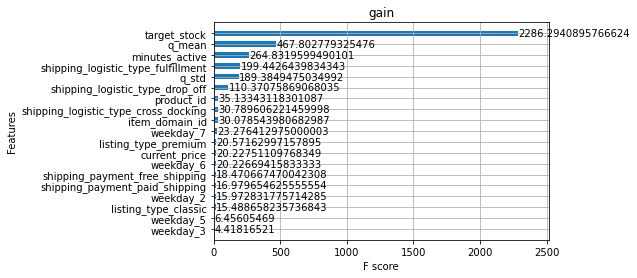

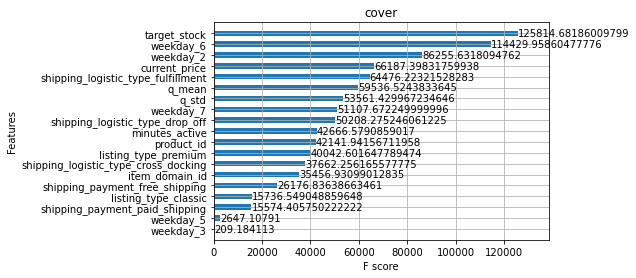

Elapsed time for model training: 0.8810754855473836 min
Training model for seed: 41 

[0]	train_sample-aft-nloglik:4.54302
[25]	train_sample-aft-nloglik:4.25739
[50]	train_sample-aft-nloglik:4.03261
[75]	train_sample-aft-nloglik:3.88026
[100]	train_sample-aft-nloglik:3.79916
[125]	train_sample-aft-nloglik:3.76989
[149]	train_sample-aft-nloglik:3.76356


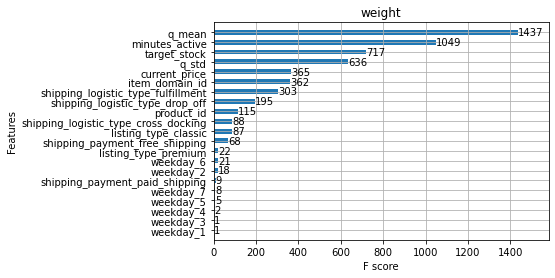

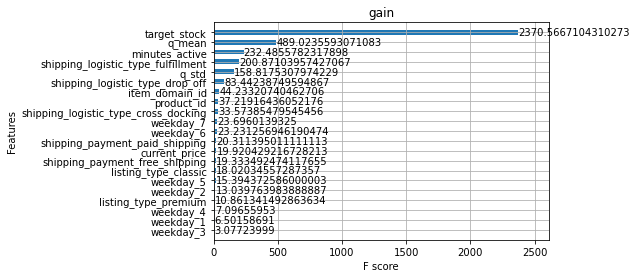

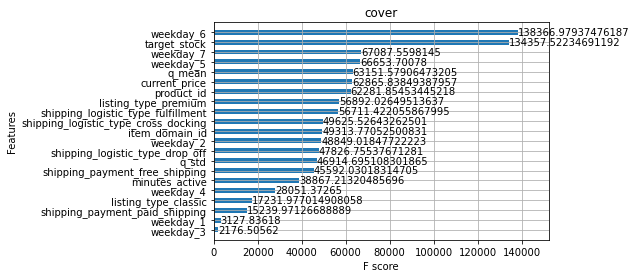

Elapsed time for model training: 0.9708491524060567 min


In [33]:
sites = ["MLA","MLB","MLM"]
models_by_site = {"MLA":list(), "MLB":list(), "MLM":list(),}
iters_by_site = {"MLA":150, "MLB":150, "MLM":150, }

SEED_LIST = [2, 11, 19, 23, 41]

for site in sites:
    print("-"*90)
    print(f"Training model for site: {site}")
    
    train_dset = (
        dataset
        .query("site_id == @site")
        .reset_index(drop=True)
    )
        
    # train data matrix
    dtrain = xgb.DMatrix(data = train_dset.loc[:, numeric_cols+categs_cols], )
    dtrain.set_float_info('label_lower_bound', train_dset.id_lower.values)
    dtrain.set_float_info('label_upper_bound', train_dset.id_upper.values)

    # sample of train data matrix for metric tracking
    sample_index = train_dset.sample(frac=0.33).index
    dtrain_sample = xgb.DMatrix(data = train_dset.loc[sample_index, numeric_cols+categs_cols], )
    dtrain_sample.set_float_info('label_lower_bound', train_dset.loc[sample_index].id_lower.values)
    dtrain_sample.set_float_info('label_upper_bound', train_dset.loc[sample_index].id_upper.values)
    
    for seed in SEED_LIST:
        print(f"Training model for seed: {seed} \n")
        tic = time.time()
        
        _model_params = dict(model_params)
        _model_params["seed"] = seed
        
        model = xgb.train(
            params = _model_params,
            dtrain = dtrain,
            num_boost_round = iters_by_site[site],
            early_stopping_rounds = iters_by_site[site]+1,
            evals = [(dtrain_sample,"train_sample")],
            verbose_eval = 25,
        )

        xgb.plot_importance(model, height=0.5, importance_type="weight", title="weight")
        xgb.plot_importance(model, height=0.5, importance_type="gain", title="gain")
        xgb.plot_importance(model, height=0.5, importance_type="cover", title="cover")
        plt.show()

        models_by_site[site].append(model)
        tac = time.time()
        print(f"Elapsed time for model training: {(tac-tic)/60.} min")

In [34]:
preds_by_site = {"MLA":list(), "MLB":list(), "MLM":list(), }
pred_dfs = list()

for site in sites:
    dtest = xgb.DMatrix(data = test.query("site_id == @site").loc[:, numeric_cols+categs_cols])
    for model in models_by_site[site]:
        preds_by_site[site].append(model.predict(dtest))
        
    df = pd.DataFrame({
        "sku":test.query("site_id == @site").sku.values, 
        "days_to_stockout":np.mean(preds_by_site[site], axis=0),
    })
    pred_dfs.append(df)
    
preds = pd.concat(pred_dfs, ignore_index=True)

In [37]:
# calculated preds mean absolute deviation

mad_list = list()
for i in range(5):
    for j in range(5):
        if i==j: continue
        mad = np.mean(np.abs(preds_by_site["MLA"][i] - preds_by_site["MLA"][j]))
        mad_list.append(mad)
print(f"MLA - mad_mean: {np.mean(mad_list):0.4f} +/- {np.std(mad_list):0.4f}")

mad_list = list()
for i in range(5):
    for j in range(5):
        if i==j: continue
        mad = np.mean(np.abs(preds_by_site["MLB"][i] - preds_by_site["MLB"][j]))
        mad_list.append(mad)
print(f"MLB - mad_mean: {np.mean(mad_list):0.4f} +/- {np.std(mad_list):0.4f}")

mad_list = list()
for i in range(5):
    for j in range(5):
        if i==j: continue
        mad = np.mean(np.abs(preds_by_site["MLM"][i] - preds_by_site["MLM"][j]))
        mad_list.append(mad)
print(f"MLM - mad_mean: {np.mean(mad_list):0.4f} +/- {np.std(mad_list):0.4f}")

MLA - mad_mean: 0.2491 +/- 0.0860
MLB - mad_mean: 0.2421 +/- 0.0889
MLM - mad_mean: 0.2276 +/- 0.0885


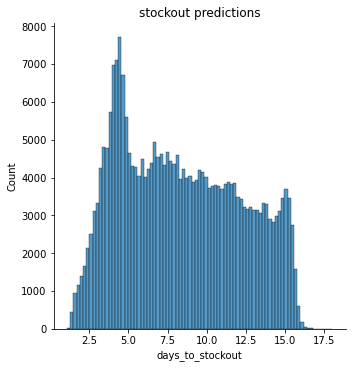

In [38]:
sns.displot(preds.days_to_stockout)
plt.title("stockout predictions")
plt.show()

***

In [39]:
class InventoryDaysPredictor():
    """
    Class to transform point predictions into probability 
    distributions over the time range.
    """

    def __init__(self, train):
        self.train = train.copy(deep=True)

    def fit(self, preds):
        parameters = self.train.groupby('sku').agg({'y':['mean', 'std']}).y
        # replace nan means by overall mean
        idx = parameters[parameters["mean"].isna()].index
        parameters.loc[idx, "mean"] = parameters["mean"].mean()
        # replace zero means by overall mean
        idx = parameters[parameters["mean"] == 0].index
        parameters.loc[idx, "mean"] = parameters["mean"].mean()
        
        # replace nan stds by overall std
        idx = parameters[parameters["std"].isna()].index
        parameters.loc[idx,"std"] = parameters["std"].mean()
        # replace nan stds by overall std
        idx = parameters[parameters["std"] == 0].index
        parameters.loc[idx,"std"] = parameters["std"].mean()
        
        self.parameters = parameters.to_dict()
        self.preds = preds.set_index("sku").copy(deep=True)

    def predict(self, sku):
        mean = self.parameters['mean'][sku]
        std = self.parameters['std'][sku]
        std_days = std/mean
        days_to_stockout = float(np.clip(self.preds.loc[sku]["pred"], a_min=1, a_max=30))
        return days_to_stockout,std_days

    def predict_proba(self, sku, dist_kwargs, lambda1, lambda2):
        days_to_stockout,std_days = self.predict(sku)
        scale = std_days * (lambda1*(days_to_stockout**lambda2))
        days = np.arange(1,31)
        probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, **dist_kwargs)        
        # if prob is zero, replace with uniform
        if np.sum(probs) == 0: return np.ones(30) / 30
        return probs/np.sum(probs)

In [40]:
# best config from sub04
dist_config = {
    "beta": 0.634505,
    "lambda1": 0.458712,
    "lambda2": 0.967726,
}

In [41]:
# dist_config = {
#     "lambda1": 0.794214,
#     "lambda2": 0.019486,
#     "lambda3": 0.998640,	
#     "lambda4": 0.727768,
# }

# plt.figure(figsize=(30,30))
# for days_to_stockout in range(1,31):
#     days = np.arange(1,31)
#     beta = (dist_config["lambda1"]* (days_to_stockout**dist_config["lambda2"])) 
#     scale = dist_config["lambda3"]*(days_to_stockout**dist_config["lambda4"])
#     probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=beta)
    
#     plt.subplot(6,5,days_to_stockout)
#     plt.plot(days, probs)
#     plt.grid()
#     plt.title(f"days_to_stockout={days_to_stockout}")
# plt.show()

In [42]:
# class InventoryDaysPredictor():

#     def __init__(self, oof):
#         self.oof = oof.set_index("sku").copy(deep=True)

#     def predict_proba(self, sku, lambda1, lambda2, lambda3, lambda4):
#         days_to_stockout = self.oof.loc[sku]["pred"]

#         days = np.arange(1,31)
#         beta = (lambda1* (days_to_stockout**lambda2)) 
#         scale = lambda3*(days_to_stockout**lambda4)
        
#         probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=beta)
#         #if prob is zero, replace with uniform
#         if np.sum(probs) == 0: return np.ones(30) / 30
        
#         return probs/np.sum(probs)

In [43]:
train = pd.read_parquet(f"{input_path}/train.parquet")
train.rename({"sold_quantity":"ds", "sold_quantity":"y"}, axis=1, inplace=True)

In [44]:
preds.rename({"days_to_stockout":"pred"}, axis=1, inplace=True)
predictor = InventoryDaysPredictor(train)
predictor.fit(preds)

In [45]:
preds_proba = list()
for sku in tqdm(preds.sku.values):    
    preds_proba.append(predictor.predict_proba(
        sku,
        dist_kwargs={"beta":dist_config["beta"]},
        lambda1=dist_config["lambda1"], 
        lambda2=dist_config["lambda2"],
    ))
preds_proba = np.array(preds_proba)
preds_proba = pd.DataFrame(preds_proba, index=preds.sku.values)

100%|██████████| 272130/272130 [01:23<00:00, 3274.64it/s]


***
## Generate the predictions

In [46]:
base_sub = "../subs/sub04.csv.gz"

test = pd.read_csv(f"{input_path}/test_data.csv")
base = pd.read_csv(base_sub, names=np.arange(30))
base = base.set_index(test.sku.values)
base = base.drop(preds_proba.index)
print("n skus from m2:  ", len(preds_proba))
print("n skus from base:", len(base))

n skus from m2:   272130
n skus from base: 279342


In [47]:
assert len(set(base.index) & set(preds_proba.index)) == 0

In [48]:
preds_proba_mrg = pd.concat([base, preds_proba], axis=0)
preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()
preds_proba_mrg

0         1         2         3         4         5         6   \
464801  0.028976  0.030700  0.032615  0.034762  0.037200  0.040014  0.043344   
645793  0.025312  0.027077  0.029045  0.031256  0.033765  0.036648  0.040017   
99516   0.037500  0.044803  0.054396  0.067610  0.087447  0.125560  0.103503   
538100  0.022834  0.024787  0.026996  0.029512  0.032410  0.035788  0.039794   
557191  0.024092  0.025257  0.026518  0.027889  0.029389  0.031041  0.032873   
...          ...       ...       ...       ...       ...       ...       ...   
129187  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
6707    0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
170355  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
246568  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
49718   0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   

              7         8         9         10        11        12        13  \
464801  0.047447  0.052933  0.063574  0.053273  0.047684  0.043530  0.040168   
645793  0.044052  0.049075  0.055805  0.067269  0.059234  0.051394  0.045841   
99516   0.077016  0.060856  0.049564  0.041158  0.034657  0.029496  0.025319   
538100  0.044660  0.050787  0.059022  0.072134  0.069600  0.057628  0.049790   
557191  0.034928  0.037265  0.039973  0.043206  0.047268  0.053043  0.054785   
...          ...       ...       ...       ...       ...       ...       ...   
129187  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
6707    0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
170355  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
246568  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
49718   0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   

              14        15        16        17        18        19        20  \
464801  0.037332  0.034878  0.032718  0.030792  0.029059  0.027487  0.026052   
645793  0.041477  0.037878  0.034824  0.032182  0.029864  0.027808  0.025969   
99516   0.021888  0.019036  0.016641  0.014613  0.012883  0.011399  0.010118   
538100  0.043884  0.039163  0.035260  0.031960  0.029123  0.026656  0.024487   
557191  0.048298  0.043986  0.040611  0.037807  0.035400  0.033290  0.031414   
...          ...       ...       ...       ...       ...       ...       ...   
129187  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
6707    0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
170355  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
246568  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
49718   0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   

              21        22        23        24        25        26        27  \
464801  0.024736  0.023523  0.022400  0.021358  0.020388  0.019483  0.018636   
645793  0.024312  0.022811  0.021445  0.020195  0.019048  0.017992  0.017017   
99516   0.009008  0.008040  0.007195  0.006453  0.005799  0.005222  0.004711   
538100  0.022567  0.020856  0.019321  0.017939  0.016689  0.015553  0.014519   
557191  0.029727  0.028197  0.026800  0.025517  0.024333  0.023236  0.022216   
...          ...       ...       ...       ...       ...       ...       ...   
129187  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
6707    0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
170355  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
246568  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   
49718   0.033300  0.033300  0.033300  0.033300  0.033300  0.033300  0.033300   

              28        29  
464801  0.017841  0.017095  
645793  0.016113  0.015275  
99516   0.004258  0.003854  
538100  0.013574  0.012707  
557191  0.021265  0.02037

In [49]:
assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-3)
assert preds_proba_mrg.max(axis=1).max() < 1

In [50]:
(preds_proba_mrg
 .round(4)
 .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
)

***